In [2]:
import pandas as pd 
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
df = pd.read_csv("Final.csv")
df.set_index('GeneName', inplace = True)

In [59]:
#10 C choices from 0 to 10000
C_options = np.logspace(0,4,10)

In [1]:
df

NameError: name 'df' is not defined

In [4]:
#Finding optimal C

X = df.drop(['Essential'], axis = 1)
Y = df['Essential']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12345)

C_options = np.logspace(0,4,10) # Create a regularization hyperparameter space
clf_parameters = {'classify__C': C_options, #Create hyperparameter options
                  'classify__penalty': ['l1']}

#Generate the pipeline. You don’t have to really scale the data if you have already done so
estimator = Pipeline(steps=[('classify',LogisticRegression(random_state=123, 
                            solver = 'liblinear', class_weight='balanced',dual=False))])

#Create a gridsearch using 5 fold cross validation. Best score will be evaluated by auc
cv_pipeline = GridSearchCV(estimator=estimator, param_grid=clf_parameters,
                           n_jobs=-1, cv = 5, verbose = True, scoring='roc_auc',
                           return_train_score=True)

#fit the grid sarch
cv_pipeline.fit(X=X_train, y=Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('classify',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=123,
                                       

In [5]:
from sklearn.metrics import confusion_matrix
y_pred_train = cv_pipeline.predict(X_train)
confusion_matrix = confusion_matrix(Y_train, y_pred_train)
print(confusion_matrix)

[[547 121]
 [ 49 322]]


In [6]:
y_pred_test = cv_pipeline.predict(X_test)
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62       167
           1       0.43      0.60      0.50        93

    accuracy                           0.57       260
   macro avg       0.57      0.58      0.56       260
weighted avg       0.61      0.57      0.58       260



In [7]:
misclassified_samples = X_test[Y_test != y_pred_test]

In [17]:
logistic_misclassified = misclassified_samples.index.tolist()

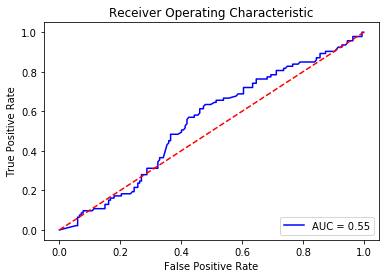

In [64]:
y_test =Y_test.astype(int) # type them as integers

probs = cv_pipeline.predict_proba(X_test)
preds = probs[:,1]#get the probability for the positive class
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [8]:
from sklearn.svm import LinearSVC

In [9]:
C_options = np.logspace(0,4,10)

clf_parameters = {'classify__C': C_options,
                  'classify__penalty': ['l1']}
estimator = Pipeline(steps=[('classify',LinearSVC(random_state=123, dual=False))])
cv_pipelinesvm = GridSearchCV(estimator=estimator, param_grid=clf_parameters,
                           n_jobs=-1, cv=5, scoring='roc_auc',
                           return_train_score=True)

In [10]:
cv_pipelinesvm.fit(X=X_train, y=Y_train)

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('classify',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=False,
                                                  fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=123, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'classify__C': array([1.00000000e+00, 2.78255940e+00, 7.742

In [11]:
y_pred_testsvm = cv_pipelinesvm.predict(X_test)
print(classification_report(Y_test, y_pred_testsvm))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       167
           1       0.44      0.55      0.49        93

    accuracy                           0.59       260
   macro avg       0.57      0.58      0.57       260
weighted avg       0.61      0.59      0.60       260



In [46]:


misclassified_samples_svm = X_test[Y_test != y_pred_testsvm]

In [47]:
svm_misclassified = misclassified_samples_svm.index.tolist()

In [42]:
from sklearn.ensemble import RandomForestClassifier
#n_estimators_options = [10,100,1000,10000,100000]# the number of trees
#min_samples_split_options = [10,100,1000,10000] # The minimum number of samples required to split an internal node
#max_features_options = [10,100,1000,10000] # The minimum number of samples required to split an internal node


#clf_parameters = {'classify__criterion': ['gini'],
#                  'classify__n_estimators': n_estimators_options,
#                 'classify__min_samples_split': min_samples_split_options,
#                 'classify__max_features': max_features_options}
#estimator = Pipeline(steps=[('classify',RandomForestClassifier(random_state=123, class_weight='balanced'))])
#cv_pipelinerf = GridSearchCV(estimator=estimator, param_grid=clf_parameters,
#                           n_jobs=-1, cv=5, scoring='roc_auc',
#                           return_train_score=True)


clf = RandomForestClassifier(random_state=123)
clf.fit(X=X_train, y=Y_train)

/Users/apetenkaya/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [53]:
y_pred_trainrf = clf.predict(X_train)
y_pred_testrf = clf.predict(X_test)

In [54]:
print(classification_report(Y_test, y_pred_testrf))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       167
           1       0.45      0.45      0.45        93

    accuracy                           0.61       260
   macro avg       0.57      0.57      0.57       260
weighted avg       0.61      0.61      0.61       260



In [65]:
from sklearn.externals import joblib
joblib.dump (cv_pipeline.best_estimator_, "lrbestestimator.pkl", compress=1)
joblib.dump (cv_pipelinesvm.best_estimator_, "svmbestestimator.pkl", compress=1)
joblib.dump (clf.base_estimator_, "rfbaseline.pkl", compress=1)

['rfbaseline.pkl']

In [3]:
#Regression Analysis on Betas
dataframe = pd.read_csv('FinalBeta.csv')
genelabel = pd.read_csv('genelabels.csv')

In [36]:
dataframe = pd.read_csv('FinalBeta.csv')
dataframe.set_index('GeneName', inplace = True)

X = dataframe.drop(['Beta'], axis = 1)
Y = dataframe['Beta']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12345)


regressor = LinearRegression().fit(X_train, Y_train) 

y_pred = regressor.predict(X_test)
              
first_model=(mean_squared_error(y_true=Y_test,y_pred=y_pred))
print(first_model)
#1.56005761821e_18

1.560057618215429e+18


In [ ]:
#Finding optimal L1_Ratio

#class sklearn.linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, 
#max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

dataframe = pd.read_csv('FinalBeta.csv')
dataframe.set_index('GeneName', inplace = True)

X = dataframe.drop(['Beta'], axis = 1)
Y = dataframe['Beta']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12345)

#regressor = LinearRegression().fit(X_train, Y_train) 

#y_pred = regressor.predict(X_test)
elastic= ElasticNet(tol=0.3)
search_elastic = GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8), 'l1_ratio':[0, 0.2, 0.4, 0.6, 
                                                                                                     0.8, 1]},
                    scoring='neg_mean_squared_error',n_jobs=1, verbose = True, refit=True,cv=5)

# #Create a gridsearch using 5 fold cross validation. Best score will be evaluated by auc
# cv_pipeline = GridSearchCV(estimator=estimator, param_grid=clf_parameters,
#                            n_jobs=-1, cv = 5, verbose = True, scoring='roc_auc',
#                            return_train_score=True)

#fit the grid sarch
search_elastic.fit(X=X_train, y=Y_train)

In [62]:
search_elastic.best_estimator_

NameError: name 'search_elastic' is not defined

In [64]:
search_elastic.best_score_

-0.015418420653634074

In [75]:
#Using Elastic Net Regression Defaults

dataframe = pd.read_csv('FinalBeta.csv')
dataframe.set_index('GeneName', inplace = True)

X = dataframe.drop(['Beta'], axis = 1)
Y = dataframe['Beta']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12345)

regress = ElasticNet().fit(X_train, Y_train)


y_pred = regress.predict(X_test)
              
model_error=(mean_squared_error(y_true=Y_test,y_pred=y_pred))
print(model_error)
#1.56005761821e_18

0.015119503999926955


In [87]:
from sklearn.linear_model import ElasticNet 
  
dataframe = pd.read_csv('FinalBeta.csv')
dataframe.set_index('GeneName', inplace = True)

X = dataframe.drop(['Beta'], axis = 1)
Y = dataframe['Beta']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12345)
# Train the model 
e_net = ElasticNet(alpha=0.1)
e_net.fit(X_train, Y_train) 
  
# calculate the prediction and mean square error 
y_pred_elastic = e_net.predict(X_test) 
mean_squared_error = np.mean((y_pred_elastic - Y_test)**2) 
print("Mean Squared Error on test set", mean_squared_error) 
  
e_net_coeff = pd.DataFrame() 
e_net_coeff["Columns"] = X_train.columns 
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_) 
e_net_coeff 

Mean Squared Error on test set 0.015119503999926953


,Columns,Coefficient Estimate
0,10FTHF5GLUtl (Lower),-0.0
1,10FTHF5GLUtl (Upper),-0.0
2,10FTHF5GLUtm (Lower),-0.0
3,10FTHF5GLUtm (Upper),-0.0
4,10FTHF6GLUtl (Lower),0.0
...,...,...
15763,r2538 (Lower),-0.0
15764,r2538 (Upper),-0.0
15765,r2539 (Lower),0.0
15766,r2539 (Upper),-0.0


In [55]:
#Using Elastic Net Regression

dataframe = pd.read_csv('FinalBeta.csv') #DataFrame with Beta as the target value
dataframe.set_index('GeneName', inplace = True)

X = dataframe.drop(['Beta'], axis = 1)
Y = dataframe['Beta']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12345)

regressor = ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.2, warm_start=False).fit(X_train, Y_train)


y_pred = regressor.predict(X_test)
              
new_model_error=(mean_squared_error(y_true=Y_test,y_pred=y_pred))
print(new_model_error)

regressor

0.015119503999926955


In [78]:
Y_test

GeneName
247_AT1      -0.002913
57665_AT1     0.074417
4720_AT1     -0.385890
6565_AT1      0.019093
10165_AT1     0.078687
                ...   
5337_AT1      0.153020
57835_AT1     0.010507
9056_AT1     -0.012149
2027_AT1     -0.065354
132158_AT1    0.080871
Name: Beta, Length: 260, dtype: float64

In [79]:
dataframe

,10FTHF5GLUtl (Lower),10FTHF5GLUtl (Upper),10FTHF5GLUtm (Lower),10FTHF5GLUtm (Upper),10FTHF6GLUtl (Lower),10FTHF6GLUtl (Upper),10FTHF6GLUtm (Lower),10FTHF6GLUtm (Upper),10FTHF7GLUtl (Lower),10FTHF7GLUtm (Lower),...,r2535m (Lower),r2535m (Upper),r2537 (Lower),r2537 (Upper),r2538 (Lower),r2538 (Upper),r2539 (Lower),r2539 (Upper),thr_mt (Lower),Beta
GeneName,,,,,,,,,,,,,,,,,,,,,
53947_AT1,-0.094323,-0.061771,-0.051165,-0.004331,0.045383,0.078885,0.039759,0.053827,0.074091,0.036798,...,-0.018348,-0.801389,0.951153,-1.456913,1.805275,-1.456913,0.277695,-20.784610,0.690347,-0.109850
65985_AT1,-0.044243,-0.061771,-0.000986,-0.004331,-0.021091,0.078885,-0.026154,0.053827,0.074091,-0.023073,...,-0.018348,-0.801389,0.951153,-1.456913,1.805275,-1.456913,0.277695,-20.784610,0.690347,0.160670
13_AT1,-0.044243,-0.061771,-0.000986,-0.004331,-0.021091,0.078885,-0.026154,0.053827,0.074091,-0.023073,...,-0.018348,-0.801389,0.951153,-1.456913,1.805275,-1.456913,0.277695,-20.784610,0.690347,-0.023140
51166_AT1,-3.985429,0.012277,-3.949980,0.059070,-5.521336,0.078885,-4.960144,6.236846,-3.251122,-3.825138,...,-0.018348,-0.801389,0.951153,-1.456913,1.805275,-1.456913,0.277695,0.048113,0.690347,0.059995
10157_AT1,-0.058712,0.012277,-0.015483,-0.125263,-0.030128,0.078885,-0.035115,0.053827,0.089752,-0.031213,...,-0.018348,-0.801389,0.951153,-1.456913,1.805275,-1.456913,0.277695,0.048113,0.690347,-0.021270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7390_AT1,-0.094323,0.012277,-0.051165,0.059070,-0.052372,0.078885,-0.057172,0.053827,0.011450,-0.051247,...,-0.018348,1.247833,-1.051356,0.686383,-0.553932,0.686383,0.277695,0.048113,0.138834,-0.126860
51741_AT1,-0.094323,0.012277,-0.051165,0.059070,-0.052372,0.078885,-0.057172,0.053827,0.011450,-0.051247,...,-0.018348,1.247833,-1.051356,0.686383,-0.553932,0.686383,0.277695,0.048113,0.138834,-0.072429
7498_AT1,-0.094323,0.012277,-0.051165,0.059070,-0.052372,0.078885,-0.057172,0.053827,0.011450,-0.051247,...,-0.018348,1.247833,-1.051356,0.686383,-0.553932,0.686383,0.277695,0.048113,0.138834,0.030918


In [ ]:
labelsdf = pd.read_csv('genelabels.csv')

In [26]:
#Analysis of MisClassified
fdr_logistic = []

genelist = labelsdf['Bigg.ID.Name'].tolist()
fdrlist = labelsdf['fdr'].tolist()
for x in range(len(logistic_misclassified)):
    fdr_logistic.append("N/A")

newdict = {genelist[i]: fdrlist[i] for i in range(len(genelist))} 


# for i in range(len(logistic_misclassified)):
#     for key, value in newdict.items():
#         if(logistic_misclassified.index[i] == key):
#             fdr_logistic[i] = value


In [31]:
for i in logistic_misclassified:
    for key, value in newdict.items():
        if(i == key):
            fdr_logistic[logistic_misclassified.index(i)] = value


In [37]:
Analysis = pd.DataFrame(list(zip(logistic_misclassified, fdr_logistic)), 
               columns =['GeneName', 'FDR']) 
Analysis

,GeneName,FDR
0,247_AT1,0.339290
1,10165_AT1,0.784880
2,5631_AT1,0.024034
3,10873_AT1,0.465470
4,1376_AT1,0.863630
...,...,...
107,4144_AT1,0.000000
108,51166_AT1,0.958120
109,8527_AT1,0.255010
110,4199_AT1,0.054390


(array([38., 15.,  7.,  7., 10.,  7.,  7.,  6.,  4., 11.]),
 array([0.      , 0.099451, 0.198902, 0.298353, 0.397804, 0.497255,
        0.596706, 0.696157, 0.795608, 0.895059, 0.99451 ]),
 <a list of 10 Patch objects>)

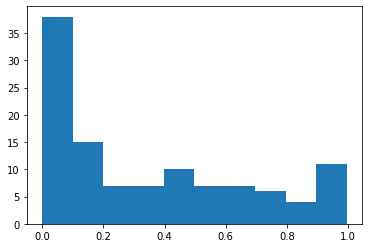

In [42]:
import matplotlib.pyplot as plt
plt.hist(Analysis['FDR'])
plt.title = "Logistic Regression misclassification "

In [48]:
fdr_svm = []

for x in range(len(svm_misclassified)):
    fdr_svm.append("N/A")

for i in svm_misclassified:
    for key, value in newdict.items():
        if(i == key):
            fdr_svm[svm_misclassified.index(i)] = value

In [49]:
Analysis2 = pd.DataFrame(list(zip(svm_misclassified, fdr_svm)), 
               columns =['GeneName', 'FDR']) 
Analysis2

,GeneName,FDR
0,6565_AT1,0.590600
1,5631_AT1,0.024034
2,10873_AT1,0.465470
3,1376_AT1,0.863630
4,1645_AT1,0.153980
...,...,...
102,4144_AT1,0.000000
103,51166_AT1,0.958120
104,4199_AT1,0.054390
105,10396_AT1,0.531950


(array([43., 14.,  5.,  5.,  7.,  8.,  7.,  5.,  4.,  9.]),
 array([0.      , 0.099451, 0.198902, 0.298353, 0.397804, 0.497255,
        0.596706, 0.696157, 0.795608, 0.895059, 0.99451 ]),
 <a list of 10 Patch objects>)

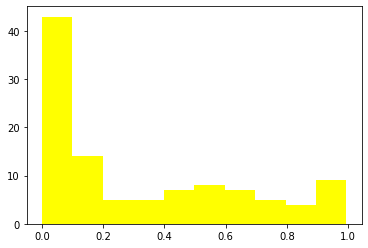

In [52]:
plt.hist(Analysis2['FDR'], color='yellow')
